In [1]:
import torchsde
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
n = 20
m = 10
ts = np.linspace(0, 10, 50)

In [3]:
np.random.seed(0)
torch.manual_seed(0)
A = np.random.randn(n, n) * 0.1
B = np.random.randn(n, m) * 0.1
x0 = np.random.randn(1,n) * 0.1

In [41]:
def matrix_rank_svd(M, tol=None):
    U, s, Vh = np.linalg.svd(M, full_matrices=False)
    return np.sum(s < tol)

def hautus_controllable(A, B, tol=None, return_details=False):
    eigvals = np.linalg.eigvals(A)

    details = []
    for lam in eigvals:
        M = np.hstack([A - lam * np.eye(n, dtype=complex), B.astype(complex)])
        r = matrix_rank_svd(M, tol=tol)
        details.append((lam, r))

    return details

In [42]:
hautus_controllable(A, B, return_details=True, tol=1e-1)

[(np.complex128(0.32743993198551746+0.3502297309986796j), np.int64(0)),
 (np.complex128(0.32743993198551746-0.3502297309986796j), np.int64(0)),
 (np.complex128(-0.17162097132835513+0.35684397809116075j), np.int64(0)),
 (np.complex128(-0.17162097132835513-0.35684397809116075j), np.int64(0)),
 (np.complex128(-0.28845529298106587+0.17236262836920835j), np.int64(0)),
 (np.complex128(-0.28845529298106587-0.17236262836920835j), np.int64(0)),
 (np.complex128(-0.31725477598393237+0j), np.int64(0)),
 (np.complex128(-0.17047913972428358+0j), np.int64(0)),
 (np.complex128(-0.10227753361709876+0.14612871404193103j), np.int64(0)),
 (np.complex128(-0.10227753361709876-0.14612871404193103j), np.int64(0)),
 (np.complex128(0.0476201142309485+0.2986181457056777j), np.int64(0)),
 (np.complex128(0.0476201142309485-0.2986181457056777j), np.int64(0)),
 (np.complex128(0.12840426405950167+0.29095864038434527j), np.int64(0)),
 (np.complex128(0.12840426405950167-0.29095864038434527j), np.int64(0)),
 (np.complex

In [4]:
def kalman_matrix(A, B):
    blocks = []
    Ak = np.eye(n)
    for _ in range(n):
        blocks.append(Ak @ B)
        Ak = A @ Ak
    return np.concatenate(blocks, axis=1)

In [5]:
C = kalman_matrix(A, B)
s = np.linalg.svd(C, compute_uv=False)
s

array([0.71798667, 0.62416931, 0.5878045 , 0.52759687, 0.48756869,
       0.48051486, 0.41446479, 0.34761898, 0.31958112, 0.28230573,
       0.20690315, 0.19565016, 0.17687741, 0.15287343, 0.13811431,
       0.11718686, 0.08736317, 0.08233052, 0.05419927, 0.03072098])

In [25]:
def sinusoidal_input(t, f):
    return np.sin(2 * np.pi * f * t)

In [ ]:
class LinearSDE(torchsde.SDEIto):
    def __init__(self, A, B, f_u, noise=0.01):
        super().__init__(noise_type="diagonal")
        self.A = torch.tensor(A, dtype=torch.float32)
        self.B = torch.tensor(B, dtype=torch.float32)
        self.f_u = f_u
        self.noise = noise
    def f(self, t, x):
        return x @ self.A + self.f_u(t, torch.linspace(0, 5, self.B.shape[1]).unsqueeze(0)) @ self.B.T

    def g(self, t, x):
        return self.noise * torch.ones_like(x)

In [27]:
model = LinearSDE(A, B, sinusoidal_input, noise=0.1)
x0_torch = torch.tensor(x0, dtype=torch.float32)
ts_torch = torch.tensor(ts, dtype=torch.float32)
xs = torchsde.sdeint(model, x0_torch, ts_torch, method="euler", dt_min=0.1)
xs_np = xs.numpy()

/tmp/ipykernel_96238/1292054937.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sin(2 * np.pi * f * t)


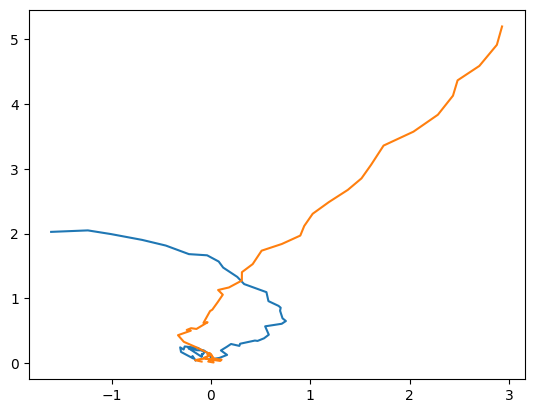

In [29]:
plt.plot(xs_np[:,0,0], xs_np[:,0,1])
plt.plot(xs_np[:,0,2], xs_np[:,0,3])